# Expectation-Maximization (EM) Algorithm
### Implementation and visualization of the EM algorithm.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse
from scipy.stats import multivariate_normal

# plot styling
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'DIN Alternate'

In [2]:
def init_cov(n):
    """ Generate initial covariance matrix """
    # ensures positive semi-definiteness
    x = np.random.standard_normal((n, n))
    return x @ x.T

In [3]:
def init_guess(n):
    """ Generates initial guess for all parameters """
    return {
        'pi': np.random.uniform(0, 1),
        'mu_1': np.random.standard_normal((n, )),
        'mu_2': np.random.standard_normal((n, )),
        'S_1': init_cov(n),
        'S_2': init_cov(n)
    }

In [4]:
def get_posteriors(x, p):
    """ Compute the posteriors """
    p_1, p_2 = multivariate_normal(p['mu_1'], p['S_1']).pdf(x), \
        multivariate_normal(p['mu_2'], p['S_2']).pdf(x)
    pi_1, pi_2 = p['pi'], 1 - p['pi']
    P_1, P_2 = p_1 * pi_1, p_2 * pi_2
    Q_1, Q_2 = P_1 / (P_1 + P_2),\
        P_2 / (P_1 + P_2)
    return np.array([Q_1, Q_2]).T

In [5]:
def e_step(x, p):
    """ Compute expectation step """
    p_1 = multivariate_normal(p['mu_1'], p['S_1']).pdf(x)
    p_2 = multivariate_normal(p['mu_2'], p['S_2']).pdf(x)
    pi_1 = p['pi']
    pi_2 = (1 - p_1)
    return np.sum(np.log(pi_1 * p_1 + pi_2 * p_2)), get_posteriors(x, p)

In [6]:
def m_step(x, p):
    """ Compute maximization step """
    N = x.shape[0]
    _, post = e_step(x, p)
    post_1, post_2 = post[:, 0].reshape((N, 1)), post[:, 1].reshape((N, 1))
    tot_post_1, tot_post_2 = np.sum(post_1), np.sum(post_2)
    pi = tot_post_1 / N
    mu_1, mu_2 = (post_1.T.dot(x) / tot_post_1).flatten(),\
        (post_2.T.dot(x) / tot_post_2).flatten()
    D_1, D_2 = x - mu_1, x - mu_2
    S_1, S_2 = D_1.T.dot(D_1 * post_1) / tot_post_1,\
        D_2.T.dot(D_2 * post_2) / tot_post_2
    return {
        'pi': pi,
        'mu_1': mu_1,
        'mu_2': mu_2,
        'S_1': S_1,
        'S_2': S_2
    }

In [7]:
def plot_cov_ellipse(mu, cov, ax, n_std=3, facecolor='none', **kwargs):
    """ Plot ellipse given mean vector and covariance structure """
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2,
    height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [8]:
def visualize_clusters(ax, params):
    """ Visualization of current clusters as ellipses """
    sns_colors = sns.color_palette().as_hex()
    plot_cov_ellipse(params['mu_1'], params['S_1'],\
        ax=ax, edgecolor=sns_colors[0], label='Group 1')
    plot_cov_ellipse(params['mu_2'], params['S_2'],\
         ax=ax, edgecolor=sns_colors[1], label='Group 2')

In [9]:
def run_em(x, p, tol=10e-8, iter_lim=100):
    """ Run the EM algorithm until convergence """
    x1, x2 = x[:, 0], x[:, 1]
    rows, cols, converged = 3, 5, False
    r, c, freq, cnt = 0, 0, 4, 1
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True)
    log_lik = np.zeros(iter_lim)
    log_lik[0], _ = e_step(x, p)
    while not converged:
        p = m_step(x, p)
        log_lik[cnt], _ = e_step(x, p)
        if (cnt % freq == 0) and ((cnt / freq) < rows * cols):
            axs[r, c].scatter(x1, x2, color='grey')
            axs[r, c].set_title('Iteration: {}'.format(cnt))
            visualize_clusters(axs[r, c], p)
            plt.draw()
            c += 1
            if c >= cols:
                r += 1
                c = 0

        if np.abs(log_lik[cnt] - log_lik[cnt - 1]) < tol:
            converged = True
            plt.scatter(x1, x2, color='grey')
            visualize_clusters(axs[r, c], p)
            plt.title('Iteration: {} \n Converged!'.format(cnt))

        cnt += 1
        if cnt == iter_lim and not converged:
            return print('Convergence failure...')

    plt.gcf().set_size_inches(14, 8)
    fig.suptitle('Cluster Evolution \n tol = {}, iter_lim = {}'.format(tol, iter_lim))
    return p, log_lik[log_lik != 0]

### We simulate, from bivariate normal distributions, two groups that are relatively separable.

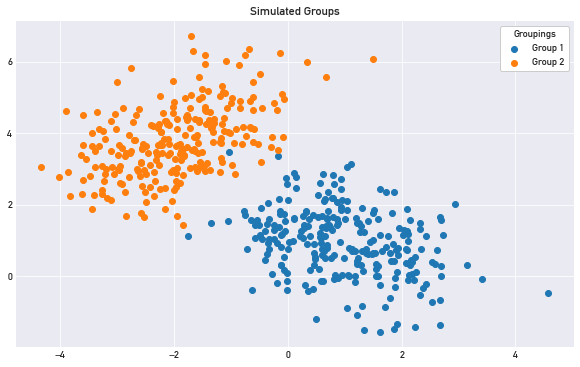

In [10]:
# simulate and visualize some data
np.random.seed(1337)
n = 250
mu_1, mu_2 = [1, 1], [-2, 3.75]
S_1, S_2 = [[1, -.4], [-.4, 1]], [[1, .5], [.5, 1]]
group_1 = np.random.multivariate_normal(mu_1, S_1, size=n)
group_2 = np.random.multivariate_normal(mu_2, S_2, size=n)
plt.scatter(group_1[:, 0], group_1[:, 1], label='Group 1')
plt.scatter(group_2[:, 0], group_2[:, 1], label='Group 2')
plt.legend(frameon=1, framealpha=1, facecolor='white', title='Groupings')
plt.title('Simulated Groups')
plt.gcf().set_size_inches(10, 6)
plt.show()

### We run the EM algorithm and visualize the cluster evolution.

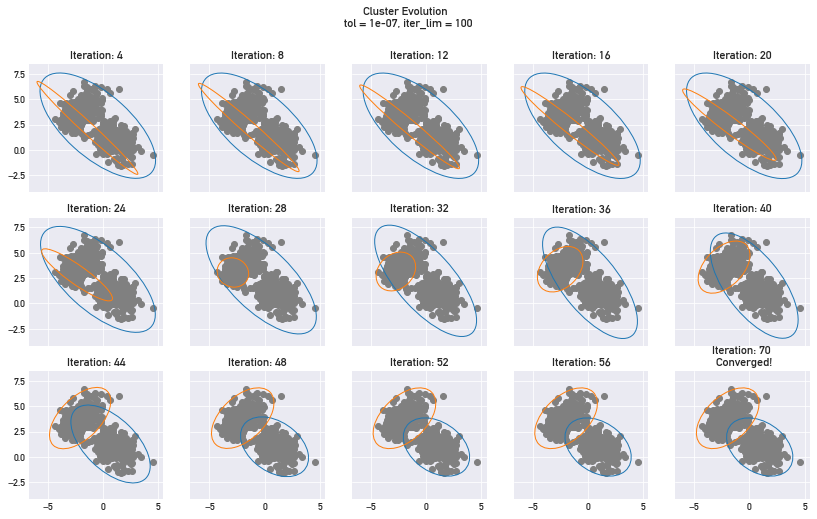

In [11]:
# for reproducibility
np.random.seed(137)

# stack and shuffle data
dat = np.concatenate([group_1, group_2], axis=0)
np.random.shuffle(dat)

# generate initial guess
g = init_guess(n=2)

# run EM-algorithm!
est_params, log_lik = run_em(dat, g)

### We obtain a convergence quite fast, although we have a relatively small tolerance for convergence.

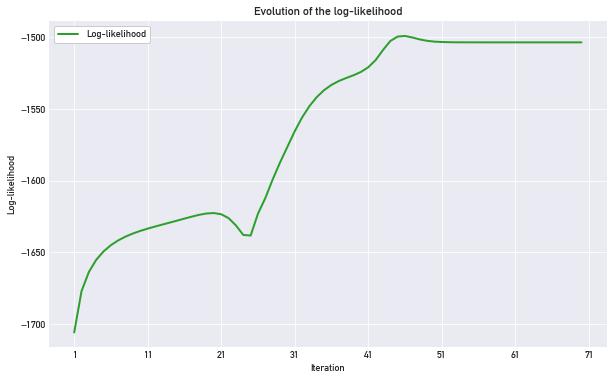

In [12]:
# check log-likelihood
sns_colors = sns.color_palette().as_hex()
plt.plot(np.arange(1, log_lik.shape[0]), log_lik[1:],\
    label='Log-likelihood', lw=2, color=sns_colors[2])
plt.xticks(np.arange(1, log_lik.shape[0] + 1, 10))
plt.ylabel('Log-likelihood')
plt.xlabel('Iteration')
plt.title('Evolution of the log-likelihood')
plt.legend(frameon=1, framealpha=1, facecolor='white')
plt.gcf().set_size_inches(10, 6)
plt.show()

### Lastly, we compare the simulated with the estimated groups, and can conclude that estimates are fairly close.

In [13]:
# compare simluated means to estimated ones
print('MEAN VECTORS')
print('Simulated:')
print(mu_1, mu_2, '\n')

print('Estimated:')
print(est_params['mu_1'].round(2), est_params['mu_2'].round(2))

MEAN VECTORS
Simulated:
[1, 1] [-2, 3.75] 

Estimated:
[0.93 0.97] [-1.97  3.82]


In [14]:
# compare simluated covariances to estimated ones
print('COVARIANCE MATRICES')
print('Simulated:')
print(np.array(S_1), '\n\n', np.array(S_2), '\n')

print('Estimated:')
print(est_params['S_1'].round(2), '\n\n', est_params['S_2'].round(2))

COVARIANCE MATRICES
Simulated:
[[ 1.  -0.4]
 [-0.4  1. ]] 

 [[1.  0.5]
 [0.5 1. ]] 

Estimated:
[[ 1.   -0.33]
 [-0.33  0.92]] 

 [[0.9  0.46]
 [0.46 1.  ]]
